Overview of methodology:

1) [Checking out the extracted data](#check_out)

2) [Calculate cuisine proportions in each subdistrict](#transform)

3) [Top cuisines visualized](#top_cuisines_each_subdist)

4) [K-means clustering](#k_means)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import branca
import branca.colormap as cm

%matplotlib inline

In [2]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.4.2


---

<a id='check_out'></a>
<u>**Checking out the data**</u>

I have 2 datasets from the scraping stage:

- Long dataframe containing all restaurant names and cuisines across all subdistricts. 

- Wide dataframe that summarizes the above by counting the number of restaurants for all cuisines (represented in columns) across all unique district <> subdistrict pair (in rows).

See below for examples.

In [3]:
count_df = pd.read_csv('./data/locations_cuisines_count_final.csv')
count_df.sample(5, random_state=1)

,districts,subdistricts,country,address,latitude,longitude,nearest_subdist,min_distance_m,dup,Afghan,...,Italian,Mediterranean,Mexican,Pakistani,Portuguese,Russian,Spanish,Sri Lankan,Middle Eastern,South American
68,Kuala Selangor,Pasir Penambang,Malaysia,"Pasir Penambang, Kuala Selangor, Malaysia",3.350226,101.253091,Kuala Selangor,1131.51,"Kuala Selangor, Pasir Penambang",4,...,0,0,0,0,0,0,0,0,3,2
77,Kuala Lumpur,Sentul,Malaysia,"Sentul, Kuala Lumpur, Malaysia",3.178618,101.695478,Sunway,1403.44,"Sentul, Sunway",23,...,29,8,11,13,5,3,4,0,44,4
44,Sabak Bernam,Sungai Besar,Malaysia,"Sungai Besar, Sabak Bernam, Malaysia",3.677714,100.988026,Sabak,9533.21,NaN,0,...,0,0,0,0,0,0,1,0,2,0
27,Kuala Selangor,Api-api,Malaysia,"Api-api, Kuala Selangor, Malaysia",3.289537,101.300839,Kuala Sungai Buloh,3709.73,NaN,0,...,0,0,0,0,0,0,0,0,0,0
63,Kuala Langat,Bandar Saujana Putra,Malaysia,"Bandar Saujana Putra, Kuala Langat, Malaysia",2.952248,101.579764,Taman Putra Prima,2379.79,"Bandar Saujana Putra, Taman Putra Prima",0,...,0,0,1,0,0,0,0,0,2,1


In [4]:
names_df = pd.read_csv('./data/locations_cuisines_names_final.csv')
names_df.rename(columns={'cuisine':'venue'}, inplace=True)
names_df.sample(5, random_state=1)

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
2273,Puchong Perdana,妈子板面,Chinese Restaurant,3.014361,101.614243
12711,Bukit Bintang,Soi 23,Thai Restaurant,3.152858,101.705373
2741,Bangsar,Lao Jiulou,Noodle House,3.110901,101.685354
5857,Damansara,Sushi Brito,Japanese Restaurant,3.113626,101.611530
3697,Damansara,Dragon-i (籠的傳人),Chinese Restaurant,3.157213,101.610238


Data quality assurance:

I got a total of **18,294 food places** across **30 cuisines** requested from Foursquare API for **78 subdistricts in Selangor and Kuala Lumpur**. 

A quick glance at the retsuarant names made me notice wrongly tagged venues as restaurants.

For example, music venues, arcades, cafes, bistros, were classified as restaurants. 

Examples below.

In [5]:
names_df['venue'].value_counts().tail(5)

Residential Building (Apartment / Condo)    1
Cafeteria                                   1
Acai House                                  1
Other Nightlife                             1
City                                        1
Name: venue, dtype: int64

Example 1:

`Pulse Ultra Club` - a music venue.

In [6]:
names_df[names_df['venue'].str.contains('music', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
6748,Bukit Bintang,Pulse Ultra Club,Music Venue,3.147828,101.712538


Example 2:

Cafeterias.

In [7]:
names_df[names_df['venue'].str.contains('cafe', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
840,Sungai Besi,Kantin Kolam Renang (UPNM),College Cafeteria,3.049157,101.725074
4474,Subang Jaya,Cafeteria,College Cafeteria,3.064110,101.600533
4574,Cyberjaya,Techno Cafe,Cafeteria,2.927431,101.662723
4822,Puchong Jaya,Cafeteria,College Cafeteria,3.064110,101.600533
10219,Puchong Jaya,Cafeteria,College Cafeteria,3.064110,101.600533


Example 3:

Grocery stores, shoe stores..

In [8]:
names_df[names_df['venue'].str.contains('store', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
14052,Kajang,7-Eleven@Kajang Prima,Grocery Store,2.983307,101.815366
14617,Bandar Sri Damansara,Jaya Grocer Sierramas,Grocery Store,3.202972,101.589149
17437,Ulu Klang,Tropicana Life,Clothing Store,3.178227,101.749273
18165,Glenmarie,Samba @ Paradigm Mall,Shoe Store,3.105005,101.596040
18177,Cyberjaya,Jabatan Pertanian,Thrift / Vintage Store,2.915300,101.683300
18190,Ulu Klang,786 restoran masha,Liquor Store,3.144613,101.767891


Example 4:

Coffee shops, dessert shops..

In [9]:
names_df[names_df['venue'].str.contains('shop', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
261,Subang Jaya,Garage 51,Coffee Shop,3.066874,101.603199
297,Bangsar,The Manhattan Fish Market,Fish & Chips Shop,3.116283,101.676483
333,Puchong Jaya,Garage 51,Coffee Shop,3.066874,101.603199
359,Bukit Bintang,dal.komm COFFEE,Coffee Shop,3.158002,101.712327
372,Sentul,dal.komm COFFEE,Coffee Shop,3.158002,101.712327
...,...,...,...,...,...
17421,Mont Kiara,瓜拉雪蘭莪潮洲海鮮飯店,Food & Drink Shop,3.188538,101.641847
17460,Damansara,Fat Olive,Coffee Shop,3.117199,101.594729
17477,Bukit Bintang,Feeka Coffee Roasters,Coffee Shop,3.148780,101.708496
18101,Kampung Sungai Tangkas,Pak abu cendol n bistro,Dessert Shop,2.973550,101.791080


Out of 18,294 food places extracted, 16,762 are restaurants (92%), while the rest may not be.

The method of assuming true positive restaurants is oversimplied (see below), but nevertheless gives us a quick glimpse of potential false positives.

In [10]:
names_df[names_df['venue'].str.contains('restau', case=False)].sample(10, random_state=1)

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
15707,Damansara,RK Restaurant,Indian Restaurant,3.152039,101.594217
17241,Sentul,Restoran Pak Punjab,Pakistani Restaurant,3.169809,101.695146
14442,Petaling Jaya,Restoran Kenchana Warisan,Indian Restaurant,3.092033,101.620764
16141,Bukit Bintang,Fatimah Food Corner,Indian Restaurant,3.150752,101.708636
8145,Shah Alam,Restoran Mega Sup Utara,Malay Restaurant,3.055561,101.530159
876,Bukit Bintang,Gerai Payung Selera Kampung,American Restaurant,3.161414,101.698463
2614,Mont Kiara,Ah Yip Herbal Soup 阿業靚湯,Chinese Restaurant,3.170723,101.667282
3788,Puchong,Mr.Pot Hotpot,Chinese Restaurant,3.025238,101.616455
8714,Cyberjaya,Sepiring,Malay Restaurant,2.922315,101.651436
9942,Damansara,Brother John Kopitiam,Malay Restaurant,3.150711,101.593880


Annoyingly, although only 30 unique cuisines were specified in the GET Requests, it seems like other cuisines were also included in the scraping.

In [11]:
names_df[names_df['venue'].str.contains('restau', case=False)]['venue'].unique().tolist()


['Afghan Restaurant',
 'African Restaurant',
 'Ethiopian Restaurant',
 'Chinese Restaurant',
 'Asian Restaurant',
 'Indian Restaurant',
 'Middle Eastern Restaurant',
 'Seafood Restaurant',
 'Fast Food Restaurant',
 'Portuguese Restaurant',
 'American Restaurant',
 'New American Restaurant',
 'Thai Restaurant',
 'Comfort Food Restaurant',
 'South American Restaurant',
 'Burmese Restaurant',
 'Malay Restaurant',
 'Cambodian Restaurant',
 'Dim Sum Restaurant',
 'Restaurant',
 'Cantonese Restaurant',
 'Hakka Restaurant',
 'Fujian Restaurant',
 'Hotpot Restaurant',
 'Henan Restaurant',
 'Hainan Restaurant',
 'Japanese Restaurant',
 'Taiwanese Restaurant',
 'Yunnan Restaurant',
 'Hunan Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Italian Restaurant',
 'Halal Restaurant',
 'Sushi Restaurant',
 'Chinese Aristocrat Restaurant',
 'Filipino Restaurant',
 'Indonesian Restaurant',
 'Javanese Restaurant',
 'Padangnese Restaurant',
 'Japanese Curry Restaurant',
 'Shabu-Shabu Restaurant',
 'Ramen 

That said, a majority of food places that were scraped are tagged as restaurants. Therefore I won't bother removing any of the scraped data.

---

<a id='transform'></a>
<u>**Calculate cuisine proportions in each subdistrict**</u>


In [12]:
normalized_count_df = count_df.copy()
normalized_count_df.drop(['districts','country','address','latitude','longitude',
                           'nearest_subdist','min_distance_m','dup'], axis=1, inplace=True)
normalized_count_df.set_index('subdistricts', inplace=True)
normalized_count_df = normalized_count_df.div(normalized_count_df.sum(axis=1), axis=0)*100

In [13]:
normalized_count_df

,Afghan,African,American,Burmese,Cambodian,Chinese,Filipino,Indonesian,Japanese,Korean,...,Italian,Mediterranean,Mexican,Pakistani,Portuguese,Russian,Spanish,Sri Lankan,Middle Eastern,South American
subdistricts,,,,,,,,,,,,,,,,,,,,,
Selayang,2.539683,0.952381,0.634921,0.00000,0.000000,29.523810,0.000000,2.222222,1.269841,0.317460,...,1.269841,0.317460,0.634921,0.634921,0.000000,0.000000,0.317460,0.000000,1.269841,0.634921
Rawang,1.826484,1.369863,1.369863,0.00000,0.000000,37.899543,0.000000,2.739726,1.826484,0.000000,...,0.456621,0.000000,0.000000,0.000000,0.456621,0.000000,0.456621,0.000000,1.369863,2.283105
Taman Templer,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,28.571429,0.000000,0.000000,0.000000,0.000000,14.285714,0.000000
Kundang,4.347826,0.000000,4.347826,0.00000,0.000000,34.782609,0.000000,8.695652,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kajang,1.376147,0.917431,0.917431,0.00000,0.000000,22.935780,0.000000,4.587156,2.981651,0.688073,...,0.917431,1.146789,1.146789,0.000000,0.688073,0.000000,0.688073,0.000000,3.899083,0.917431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16 Sierra,2.112676,0.704225,2.112676,0.00000,0.000000,9.154930,0.000000,3.521127,2.112676,0.704225,...,0.000000,1.408451,0.704225,0.000000,0.000000,0.000000,0.000000,0.000000,4.225352,2.112676
Taman Putra Prima,0.724638,2.173913,0.000000,0.00000,0.000000,30.434783,0.000000,1.449275,1.449275,0.724638,...,0.724638,0.000000,1.449275,0.000000,0.000000,0.000000,0.000000,0.724638,1.449275,3.623188
Taman Mas,0.000000,0.000000,0.000000,0.00000,0.000000,31.372549,0.000000,3.921569,0.000000,0.000000,...,0.980392,0.000000,0.980392,0.000000,0.000000,0.000000,0.980392,0.000000,2.941176,0.980392


---

<a id='top_cuisines_each_subdist'></a>
<u>**Top cuisines visualized**</u>

In [14]:
subdistricts_output = []
topcuisines_output = []
percents_output = []

subdistricts_output_list = []
topcuisines_output_list = []
percents_output_list = []

for i,j in normalized_count_df.iterrows():
    subdistricts = i
    subdistricts_output.extend([subdistricts]*3)
    subdistricts_output_list.append(subdistricts)
    
    topcuisines = normalized_count_df.loc[i,:].sort_values(ascending=False).head(3).to_frame().reset_index()['index'].tolist()
    topcuisines_output.extend(topcuisines)
    topcuisines_output_list.append(topcuisines)
    
    percents = normalized_count_df.loc[i,:].sort_values(ascending=False).head(3).to_frame().reset_index()[i].tolist()
    percents_output.extend(percents)
    percents_output_list.append(percents_output)
    
top3_cuisines_long = pd.DataFrame(list(zip(subdistricts_output, topcuisines_output, percents_output)),
                          columns=['subdistrict', 'top_cuisines', '%'])
top3_cuisines_long

,subdistrict,top_cuisines,%
0,Selayang,Malay,31.746032
1,Selayang,Chinese,29.523810
2,Selayang,Indian,12.063492
3,Rawang,Chinese,37.899543
4,Rawang,Malay,26.940639
...,...,...,...
229,Bukit Bintang,Indonesian,7.230658
230,Bukit Bintang,Indian,7.230658
231,Sentul,Malay,12.562814
232,Sentul,Indian,12.562814


In [15]:
# create a new df containing the top 3 cuisines for each subdistrict using the lists above
top3_cuisines_wide = pd.DataFrame(topcuisines_output_list, columns=['1st','2nd','3rd'])
top3_cuisines_wide['subdistrict'] = subdistricts_output_list
top3_cuisines_wide['combine'] = top3_cuisines_wide['1st'] + ', ' + top3_cuisines_wide['2nd'] + ', ' + top3_cuisines_wide['3rd']
top3_cuisines_wide


,1st,2nd,3rd,subdistrict,combine
0,Malay,Chinese,Indian,Selayang,"Malay, Chinese, Indian"
1,Chinese,Malay,Indian,Rawang,"Chinese, Malay, Indian"
2,Pakistani,Malay,Indian,Taman Templer,"Pakistani, Malay, Indian"
3,Malay,Chinese,Thai,Kundang,"Malay, Chinese, Thai"
4,Chinese,Malay,Indian,Kajang,"Chinese, Malay, Indian"
...,...,...,...,...,...
73,Malay,Thai,Indian,16 Sierra,"Malay, Thai, Indian"
74,Chinese,Malay,Indian,Taman Putra Prima,"Chinese, Malay, Indian"
75,Malay,Chinese,Indian,Taman Mas,"Malay, Chinese, Indian"
76,Malay,Indonesian,Indian,Bukit Bintang,"Malay, Indonesian, Indian"


In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
# format % to whole numbers
top3_cuisines_long['%'] = round(top3_cuisines_long['%'],0).astype(int)

The bar charts below show us locations that are similar in their top 3 cuisines. 

The darker bars are local cuisines (Malay, Chinese, Indian), while the ligher ones are foreign cuisines. 

Some observations:

- Local cuisines dominate the top 3 cuisines across most neighourhoods. 

- Across the subdistricts, all neighborhoods have at least one of the local cuisines (Malay, Chinese, Indian) as their top 3.

- A handful of neigborhoods (see last few charts) have relatively low proportions (< 20%) of their respective top 3 cuisines, which indicates a higher diversity of food cuisines in these areas. 

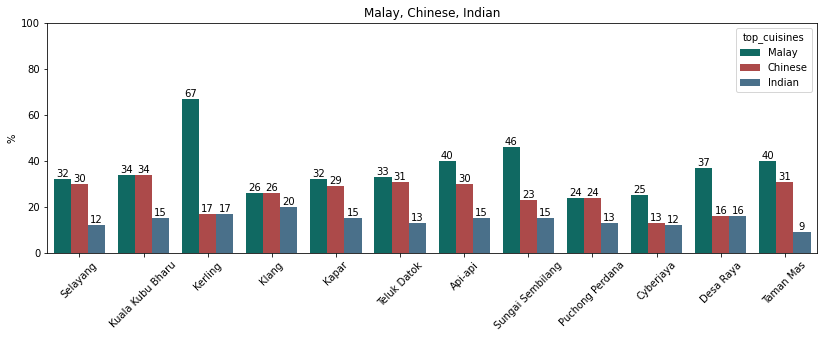

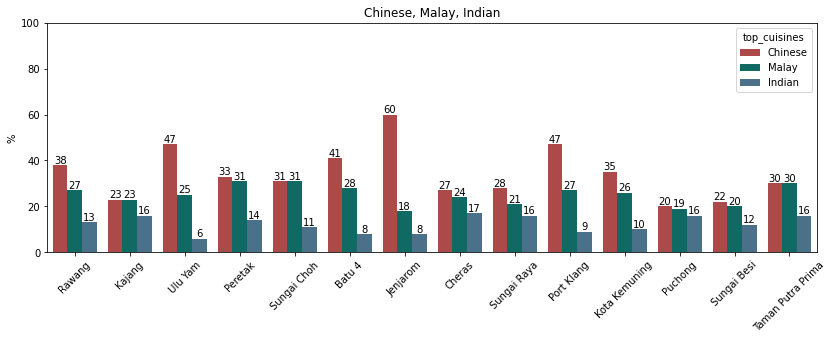

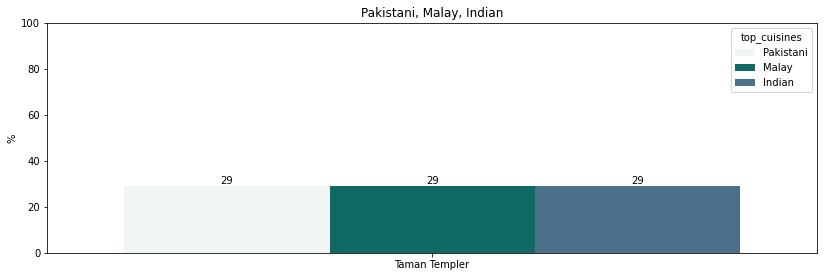

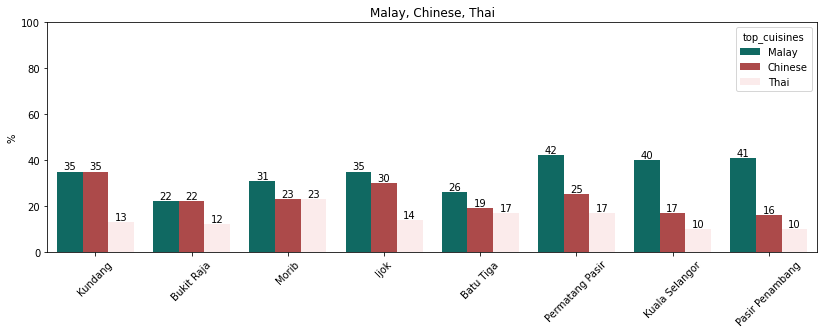

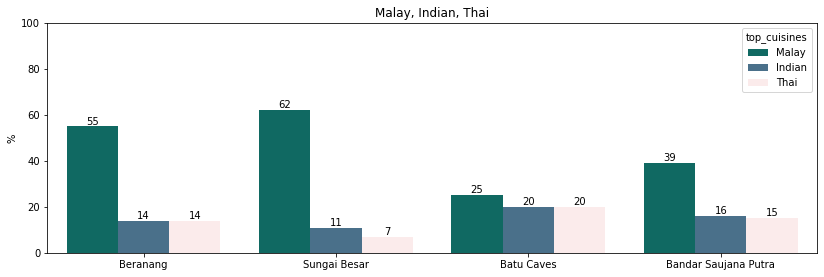

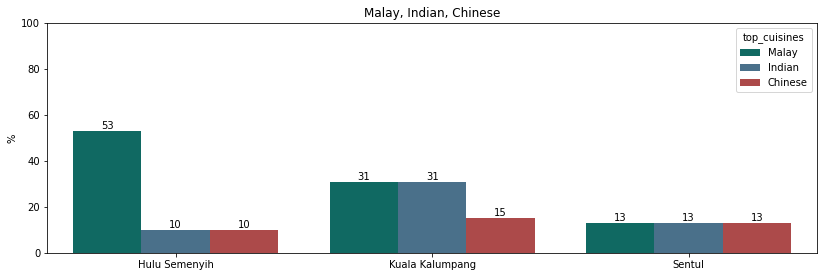

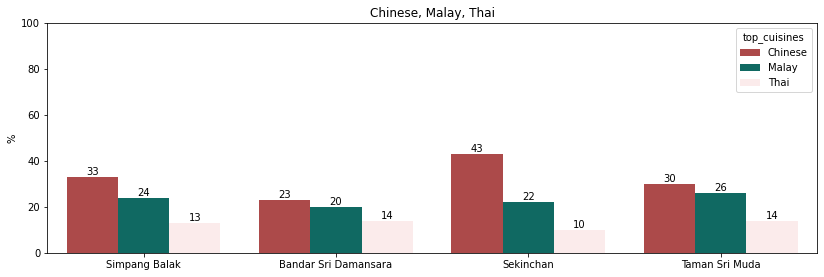

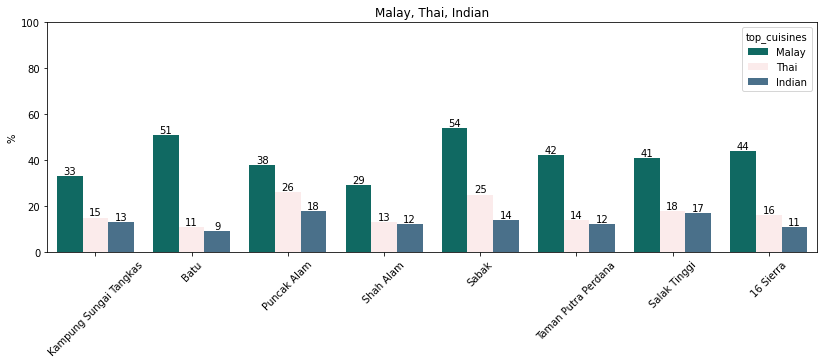

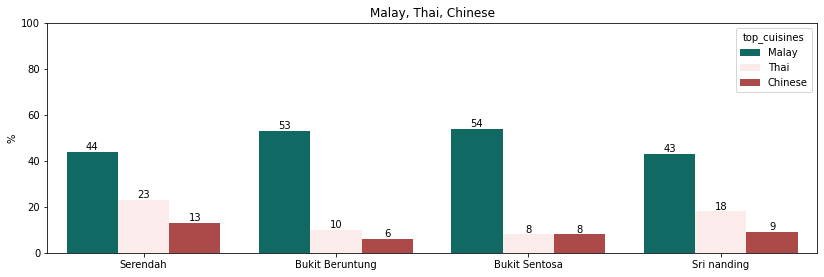

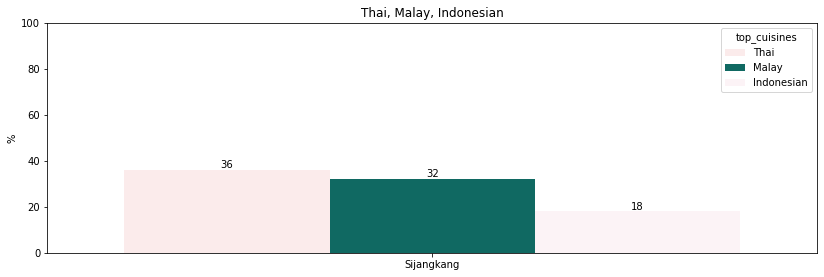

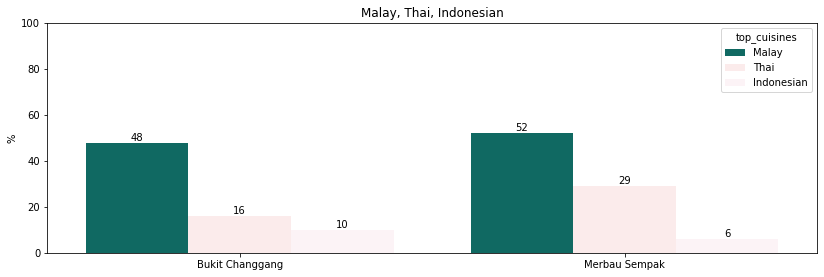

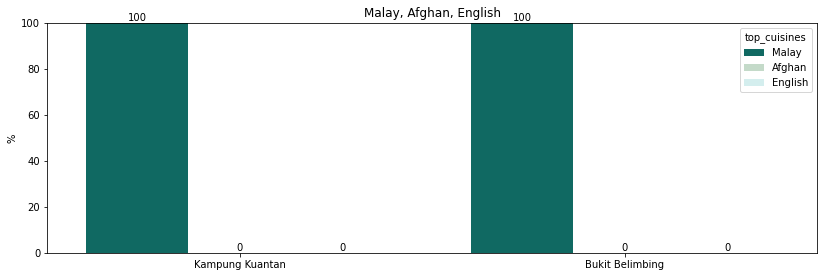

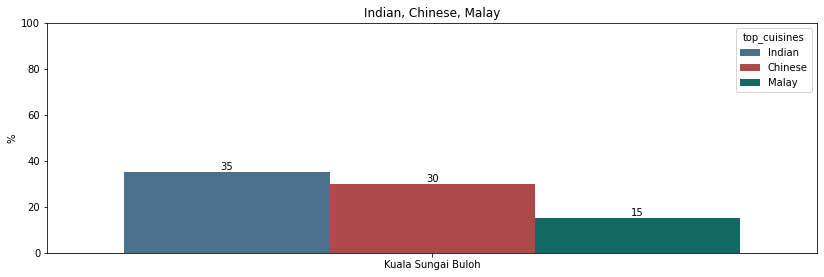

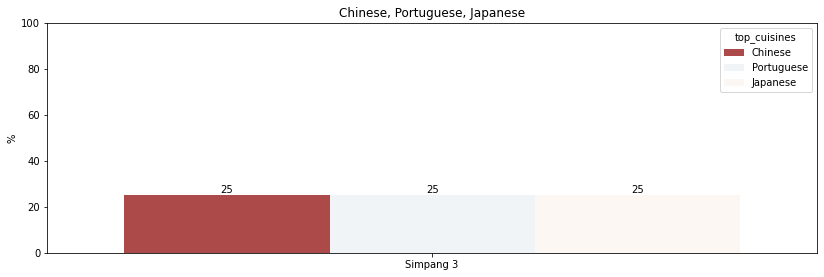

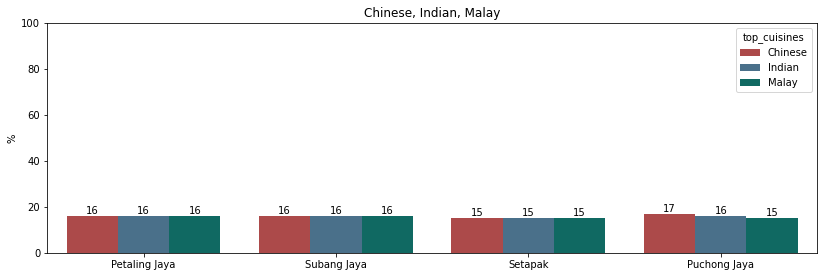

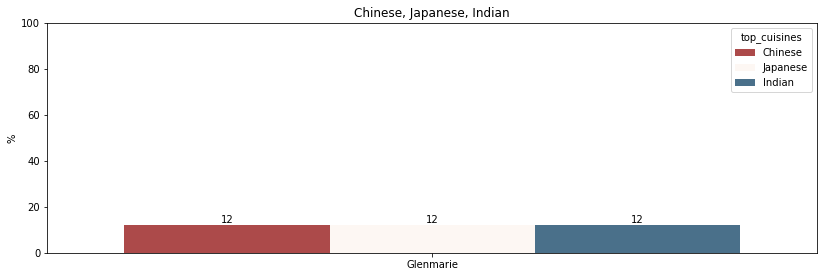

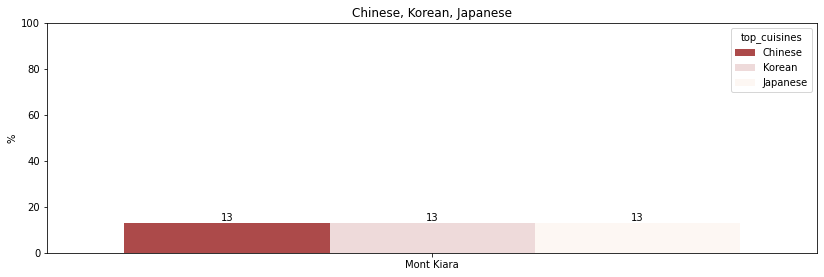

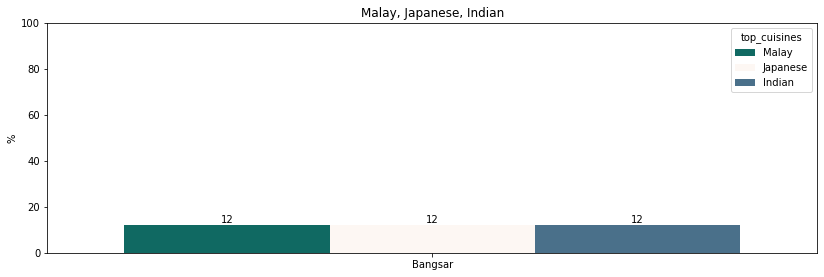

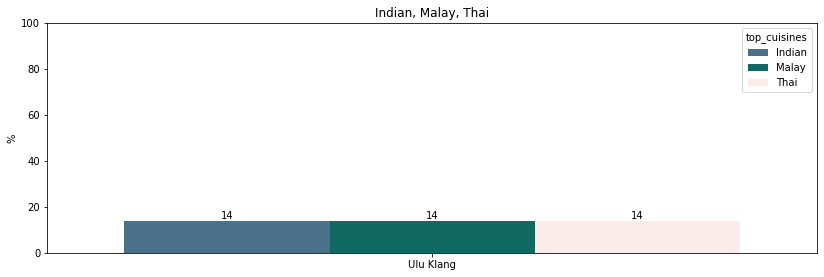

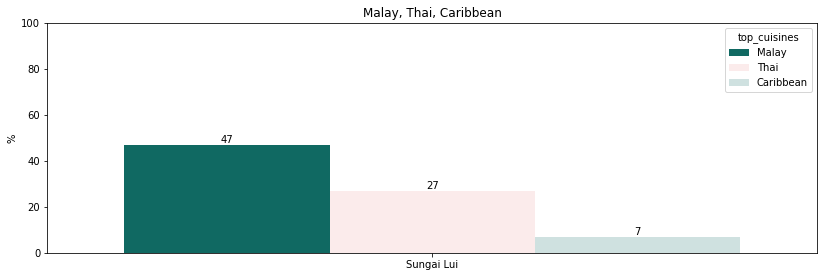

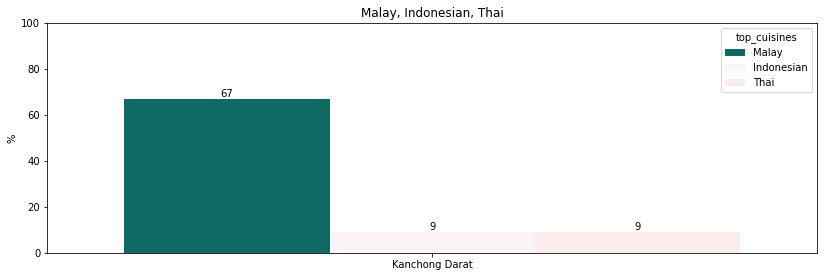

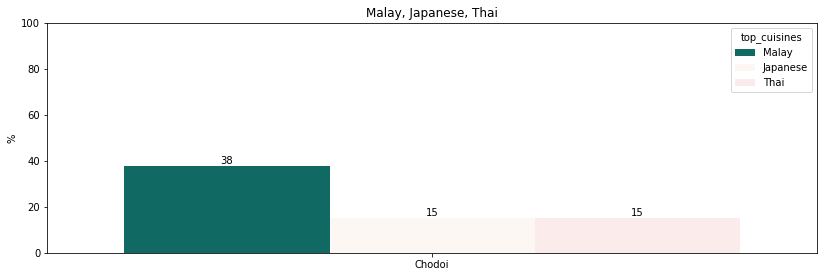

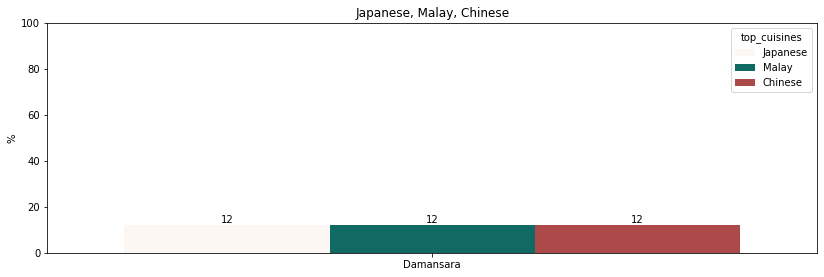

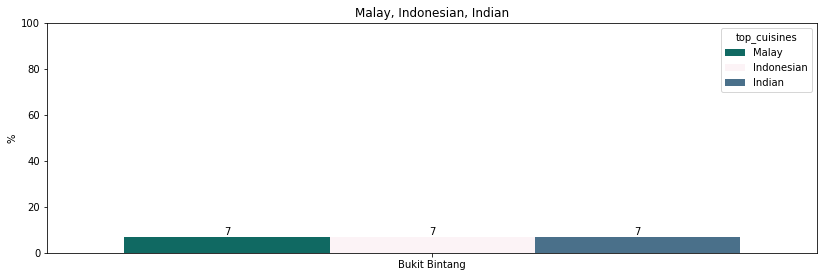

In [18]:
unique_top3 = top3_cuisines_wide['combine'].unique().tolist()

palette = {'Malay':'#01786f',
           'Chinese':'#bd3939',
           'Indian':'#407294',
           'Pakistani':'#f0f6f5',
           'Thai':'#fee9e8',
           'Indonesian':'#fdf2f6',
           'Afghan':'#c0dec7',
           'English':'#d0f2f2',
           'Portuguese':'#eff4f8',
           'Japanese':'#fff7f1',
           'Korean':'#f1d7d7',
           'Caribbean':'#cce4e2'}

for i in enumerate(unique_top3):
    viz = pd.DataFrame(columns=['subdistrict', 'top_cuisines', '%'])
    subdistricts = top3_cuisines_wide[top3_cuisines_wide['combine'] == i[1]]['subdistrict'].tolist()
    for j in subdistricts:
        top3_cuisines_long_subdist = top3_cuisines_long[top3_cuisines_long['subdistrict'] == j]
        viz = viz.append(top3_cuisines_long_subdist)
    plt.figure(figsize=(80,60))
    plt.subplot(12, 5, i[0]+1)
    ax = sns.barplot(data=viz, x='subdistrict', y='%', hue='top_cuisines', ci=None, palette=palette)
    plt.title(i[1])
    plt.ylim([0,100])
    plt.xlabel('')
    if len(viz['subdistrict'].unique().tolist()) >= 5:
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=360)
    for a in ax.containers:
        ax.bar_label(a);
    

---

<a id='k_means'></a>
<u>**K-means clustering**</u>

K-means clustering is an **unsupervised machine learning model** that groups data together based on similar characteristics. 

There are certain advantages to K-means clustering such as lower computational power required. 

Some disadvantages include:

- Selection of centroids for clustering

- May result in different clusters as new iterations of the model are applied (due to random placements of centroids at initiation)

- Sensitive to outliers. Other clustering methods may be used such as K-median clustering

Several things to prep before implmentating K-means:

1) Feature scaling to standard normal distribution with a mean of 0 and a SD of 1. Although I don't think this is necessary in my case as my features are of the same scale - frequencies. 

2) PCA, which I use to reduce input dimensionality. 

In [19]:
final_df = count_df.copy()
final_df.drop(['districts','country','address','latitude','longitude',
                           'nearest_subdist','min_distance_m','dup'], axis=1, inplace=True)

In [20]:
final_df.head(3)

,subdistricts,Afghan,African,American,Burmese,Cambodian,Chinese,Filipino,Indonesian,Japanese,...,Italian,Mediterranean,Mexican,Pakistani,Portuguese,Russian,Spanish,Sri Lankan,Middle Eastern,South American
0,Selayang,8,3,2,0,0,93,0,7,4,...,4,1,2,2,0,0,1,0,4,2
1,Rawang,4,3,3,0,0,83,0,6,4,...,1,0,0,0,1,0,1,0,3,5
2,Taman Templer,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,1,0


In [21]:
# import scaler
from sklearn.preprocessing import StandardScaler

X = final_df.drop(['subdistricts'], axis=1).values
y = final_df['subdistricts'].values

X = StandardScaler().fit_transform(X)

In [22]:
# perform PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data=principalComponents)

print(f"Components: {pca.n_components_}\nTotal explained variance: {round(pca.explained_variance_ratio_.sum(),5)}")

Components: 2
Total explained variance: 0.75667


I apply the Elbow Method to choose the optimal number of K clusters. 

Looks like 4 is the most optimum, after which the distortions and intertias start decreasing at a similar rate.


In [23]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [24]:
distortions = []
inertias = []
mapping = {}
mapping2 = {}
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    y_predict = kmeanModel.fit(X)
    distortion = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0]
    inertia = kmeanModel.inertia_
    distortions.append(distortion)
    inertias.append(inertia)
    mapping[k] = distortion
    mapping2[k] = inertia

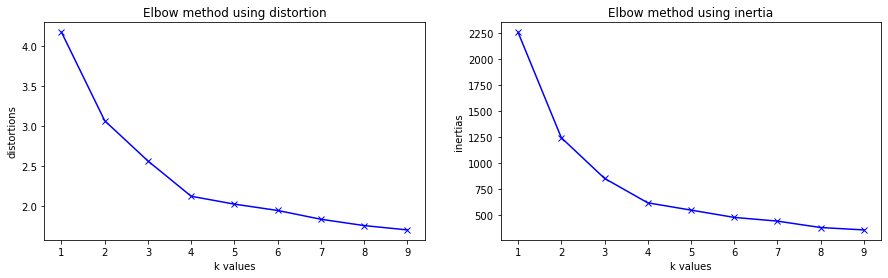

In [25]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k values')
plt.ylabel('distortions')
plt.title('Elbow method using distortion')

plt.subplot(1, 2, 2)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k values')
plt.ylabel('inertias')
plt.title('Elbow method using inertia');

Fitting algorithm:

The Folium Map below shows us clusters that generally revolve around the central KLCC area. The clusters start to differentiate in cuisine diversity the further away they get from the central area. 

Let's delve a little deeper.

In [26]:
kmeanModel = KMeans(n_clusters=4, random_state=1)
clusters = kmeanModel.fit_predict(X)

In [27]:
# label normalized_count_df, that is derived from count_df
normalized_count_df = normalized_count_df.reset_index()
normalized_count_df['label'] = clusters
normalized_count_df = pd.merge(left=normalized_count_df, right=count_df[['subdistricts','latitude','longitude']], 
                            left_on='subdistricts', right_on='subdistricts')

# label count_df
count_df['label'] = clusters
# clustered_final_df = pd.merge(left=final_df, right=count_df[['subdistricts','latitude','longitude']], 
#                             left_on='subdistricts', right_on='subdistricts')

# color map labels
color_dict = {0:'blue', 1:'green', 2:'lightpurple', 3:'red'}

In [28]:
from folium.plugins import MarkerCluster

In [29]:
map_f3 = folium.Map()

for i,j in count_df.iterrows():
    folium.CircleMarker([j['latitude'], j['longitude']], 
                  popup=j['subdistricts'],
                  color='b',
                  fill_color=color_dict[j['label']],
                  fill=True,
                  fill_opacity=1,
                  radius=7).add_to(map_f3)
    
sw2 = count_df[['latitude','longitude']].min().values.tolist()
ne2 = count_df[['latitude','longitude']].max().values.tolist()

map_f3.fit_bounds([sw2, ne2])
map_f3    

Delving deeper: 

Let's analyze the data across the clusters. 

1) Number of restaurants

2) Diversity of cuisines (number of unique cuisines)

3) Dominance of cuisines (distribution of restaurants across cuisines i.e are most offerings dominated by only a handful of cuisines? Or is there a relatively equal spread of offerings between all cuisines)

4) Ratio of international to local cuisines

**Calculate number of restaurants** and store values under df `metric1` column `sum`.

`metrics_final_df` would be the df to combine all new metric dataframes.

In [30]:
# drop certain features from count_df
count_df.drop(['districts','country','address','nearest_subdist','min_distance_m','dup',
               'latitude','longitude'], axis=1, inplace=True)

In [31]:
count_df.set_index(['subdistricts','label'], inplace=True)
count_df['supply'] = count_df.apply(lambda x: (x.sum()).astype(int), axis=1)
metric1 = count_df[['supply']]

In [32]:
metric1.head(3)

,,supply
subdistricts,label,
Selayang,3,315
Rawang,3,219
Taman Templer,0,7


**Calculate diversity of cuisines** and store values under df `metric2` column `unique`.

In [33]:
count_df.drop(['supply'], axis=1, inplace=True)

In [34]:
metric2 = (count_df != 0).sum(axis=1).to_frame().rename(columns={0:'diversity'})

In [35]:
metric2.head(3)

,,diversity
subdistricts,label,
Selayang,3,21
Rawang,3,16
Taman Templer,0,4


**Calculate dominance of cuisines** and store values under df `metric3` column `dominance`.

To gauge cuisine dominance, I calculate the SD of cuisine count for each subdistrict - the larger the SD, the larger the spread of cuisines, the less dominating cuisines are. 

In [36]:
metric3 = count_df.replace(0, np.NaN).apply(lambda x: x.std(), axis=1).to_frame().rename(columns={0:'dominance'}).fillna(0)

In [69]:
metric3.tail(10)

,,dominance
subdistricts,label,
Pasir Penambang,0,9.542751
Damansara,1,35.583696
Puchong,3,31.329218
Puchong Jaya,1,31.182260
Sungai Besi,3,27.291146
16 Sierra,0,15.873908
Taman Putra Prima,0,14.438045
Taman Mas,0,13.426568
Bukit Bintang,2,41.185212


**Calculate ratio of international to local cuisines**

In [38]:
local = ['Malay', 'Chinese', 'Indian']
international = count_df.columns[~count_df.columns.isin(local)].tolist()

In [39]:
local_sum_df = count_df[local].sum(axis=1).to_frame().rename(columns={0:"sum_local"})
international_sum_df = count_df[international].sum(axis=1).to_frame().rename(columns={0:"sum_international"})

In [40]:
metric4 = pd.concat([local_sum_df, international_sum_df], axis=1)
metric4['ratio_int2local'] = (metric4['sum_international']/metric4['sum_local']).values
metric4.drop(['sum_local', 'sum_international'], axis=1, inplace=True)

In [41]:
metric4.head(3)

,,ratio_int2local
subdistricts,label,
Selayang,3,0.363636
Rawang,3,0.288235
Taman Templer,0,0.750000


Now, I combine all four metric dataframes.

In [42]:
metric_count_df = pd.concat([metric1, metric2, metric3, metric4], axis=1)
metric_count_df.reset_index(inplace=True)

metric_count_df = pd.merge(left=metric_count_df, right=normalized_count_df[['subdistricts','latitude','longitude']],
         on='subdistricts')
metric_count_df.head()

,subdistricts,label,supply,diversity,dominance,ratio_int2local,latitude,longitude
0,Selayang,3,315,21,29.161619,0.363636,3.253712,101.653901
1,Rawang,3,219,16,23.817973,0.288235,3.318847,101.574983
2,Taman Templer,0,7,4,0.500000,0.750000,3.297962,101.637427
3,Kundang,0,23,6,3.311596,0.437500,3.283333,101.516670
4,Kajang,3,436,23,31.209670,0.614815,2.983234,101.790659


In [43]:
map_f4 = folium.Map()

colormap=cm.LinearColormap(colors=['black','blue'], 
                           index=[metric_count_df['supply'].min(), metric_count_df['supply'].max()], 
                           vmin=metric_count_df['supply'].min(), vmax=metric_count_df['supply'].max())

for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup=j['subdistricts'],
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap(j['supply'])).add_to(map_f4)
    
sw2 = metric_count_df[['latitude','longitude']].min().values.tolist()
ne2 = metric_count_df[['latitude','longitude']].max().values.tolist()

map_f4.fit_bounds([sw2, ne2])
map_f4.add_child(colormap)
map_f4  

In [44]:
map_f5 = folium.Map()

colormap=cm.LinearColormap(colors=['black','yellow'], 
                           index=[metric_count_df['diversity'].min(), metric_count_df['diversity'].max()], 
                           vmin=metric_count_df['diversity'].min(), vmax=metric_count_df['diversity'].max())

for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup=j['subdistricts'],
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap(j['diversity'])).add_to(map_f5)
    
sw2 = metric_count_df[['latitude','longitude']].min().values.tolist()
ne2 = metric_count_df[['latitude','longitude']].max().values.tolist()

map_f5.fit_bounds([sw2, ne2])
map_f5.add_child(colormap)
map_f5

In [45]:
map_f6 = folium.Map()

colormap=cm.LinearColormap(colors=['black','orange'], 
                           index=[metric_count_df['dominance'].min(), metric_count_df['dominance'].max()], 
                           vmin=metric_count_df['dominance'].min(), vmax=metric_count_df['dominance'].max())

for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup=j['subdistricts'],
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap(j['dominance'])).add_to(map_f6)
    
sw2 = metric_count_df[['latitude','longitude']].min().values.tolist()
ne2 = metric_count_df[['latitude','longitude']].max().values.tolist()

map_f6.fit_bounds([sw2, ne2])
map_f6.add_child(colormap)
map_f6

In [46]:
map_f7 = folium.Map()

colormap=cm.LinearColormap(colors=['black','red'], 
                           index=[metric_count_df['ratio_int2local'].min(), metric_count_df['ratio_int2local'].max()], 
                           vmin=metric_count_df['ratio_int2local'].min(), vmax=metric_count_df['ratio_int2local'].max())

for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup=j['subdistricts'],
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap(j['ratio_int2local'])).add_to(map_f7)
    
sw2 = metric_count_df[['latitude','longitude']].min().values.tolist()
ne2 = metric_count_df[['latitude','longitude']].max().values.tolist()

map_f7.fit_bounds([sw2, ne2])
map_f7.add_child(colormap)
map_f7